### Artificial Neural network from scratch

Attempt at implementing a neural network from scratch without looking at much documentation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import e
import pandas as pd

In [2]:
#train_data = pd.read_csv("https://pjreddie.com/media/files/mnist_train.csv")
#test_data = pd.read_csv("https://pjreddie.com/media/files/mnist_test.csv")

train_data = pd.read_csv("data/mnist_train.csv")
test_data = pd.read_csv("data/mnist_test.csv")

In [3]:
#np.random.seed(100) this does not work fidn way for reproducable results 
train_data = np.array(train_data)
test_data = np.array(test_data)

np.random.shuffle(train_data)
print(train_data[:5] )

np.random.shuffle(test_data)


train_labels = train_data[:, 0]
train_data = train_data[:, 1:]/ 255 # normalise 0, 1 try -1, 2 maybe 

test_labels = test_data[:, 0]
test_data = test_data[:, 1:]/ 255

batch_size = 60  #128

learning_rate = 0.01###### doesent do anything :0

num_epochs = 3000

num_train_batches = len(train_data) // batch_size # devides and then floors result 
num_test_batches = len(test_data) // batch_size

num_samples, num_features, num_classes = train_data.shape[0], train_data.shape[1], len(np.unique(train_labels))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [8 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]]


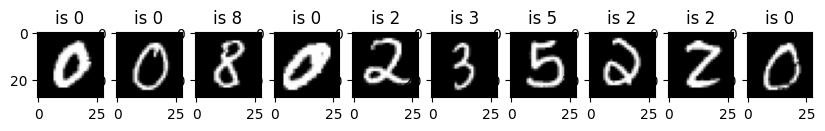

In [4]:
plt.figure(figsize=(10,10))
for i in range(10):
    label = train_labels[i]   
    pixels = train_data[i]

    # Reshape the pixels for this image only
    pixels = pixels.reshape(28, 28)

    plt.subplot(1, 10, i+1)
    plt.title("is {label}".format(label=label))
    plt.imshow(pixels, cmap="gray")

plt.show()


In [ ]:
class Linear():
    def forward(self, input):
        return input
    
    def backward(self, input):
        return 1    
      
class Step():
    def forward(self, input):
        return np.where(input >= 0, 1, 0) # creates binrary array depending if element is greater or equal to 0

class ReLU():
    def forward(self, input):
        return np.maximum(0, input) # input = 11, -1, 2, or max only outputs one scalar, np.where(self.input > 0, self.input, 0) if self.input
    
    def backward(self, input):
        return np.where(input >0, 1, 0) 
    
class Leaky_ReLU():
    def forward(self, input):
        return np.maximum(0.1*input, input) 
    
class Sigmoid():
    def forward(self, input):
        input = np.clip(input, -500, 500)  # avoid overflow - is the correct way to implement?
        return 1/ (1 + np.exp(-input))  
    
class TanH():
    def forward(self, input):
        input = np.clip(input, -500, 500)  # avoid overflow
        return (2/ (1+ np.exp(-2*input))) -1 
    
class Softmax():
    def forward(self, input):
        shifted_values = input - np.max(input, axis=1, keepdims= True)  # stabalised to avoid overflow 
        exponetials = np.exp(shifted_values)
        self.output = exponetials/ np.sum(exponetials, axis=1, keepdims=True)
        return self.output
    
        #when using sigmoid + softmax // make cleaner way to do this with if statment! 

#    def backward(self, input):
#        s = self.output.reshape(-1, 1)
#        return np.diagflat(s) - np.dot(s, s.T)
        # Compute the Jacobian matrix: diag(s) - s * s^T
        # maybe go through 3b1b series calculus and integration AND TRY PROBLEMS then come back to this
        


In [6]:
class Dense():
    def __init__(self, num_inputs, num_neurons, activation_function):
        self.weights = np.random.uniform(-1, 1, (num_neurons, num_inputs)) # -1, 1 for tanh and sigmoid and 0, 1 for ReLU - maybe add if statement
        self.biases = np.random.uniform(-1, 1, (num_neurons)) # often initialised to 0 maybe change - read up
        self.activations = np.empty((num_neurons))
        self.activation_function = activation_function
        self.num_neurons = num_neurons

    def forward(self, input_activations):
        #self.activations = self.activation_function(np.dot(self.weights, input_activations) + self.biases) for singular input, no batch, size: 784,
        self.pre_activation = np.dot(input_activations, self.weights.T) + self.biases
        self.activations = self.activation_function.forward(self.pre_activation) # for batch, size: batch, 784
        return self.activations
    
    def backward(self, upstream_derivatives, input_activations): 
        #upstream_derivatives *= self.activation_function.backward(self.pre_activation)

        if not isinstance(self.activation_function, Softmax):       # for simpliefied derivative in the case of cce + softmax we dont want the next line of code
            upstream_derivatives *= self.activation_function.backward(self.pre_activation)

        self.derivatives_weights = np.dot(upstream_derivatives.T, input_activations)   # destinction between gradients, derivatives - since they are part of gradient might be better to call them gradient_..
        self.derivatives_biases = np.sum(upstream_derivatives, axis=0)                  # derivative of addition 1
        self.derivatives_wrt_inputs = np.dot(upstream_derivatives, self.weights)



        #self.derivatives_weights = np.dot(upstream_derivatives.T, input_activations)   # destinction between gradients, derivatives - since they are part of gradient might be better to call them gradient_..
        #self.derivatives_biases = np.sum(upstream_derivatives, axis=0)                  # derivative of addition 1
        #self.derivatives_wrt_inputs = np.dot(upstream_derivatives, self.weights)



In [7]:
class MAE():
    def forward(self, predictions, targets):
        return np.mean(np.absolute(predictions - targets))
    
    def backward(self):
        pass

class MSE():
    def forward(self, predictions, targets):
        predictions = np.clip(predictions, -1e4, 1e4) 
        targets = np.clip(targets, -1e4, 1e4)
        return np.mean((predictions- targets)**2)
    
    def backward(self, predictions, targets):
        return (2/len(targets)) * (predictions - targets)           # doesent seem computationaly effiecent to find length each time
    
class CCE():
    def forward(self, predictions, target): 
        predictions_at_target_indices = np.sum(predictions*target, axis=1) # element-wise multiplication
        predictions_at_target_indices = np.clip(predictions_at_target_indices, 1e-10, 1) #1e-10, 1 - 1e-10 still confused a bit - some say it will skew results
        return np.mean(-np.log(predictions_at_target_indices)) # -log of prediction at index = ground truth 
    
    def backward(slef, predictions, target):###########################
        #N = predictions.shape[0]  # Number of samples
        #return -(1/N) * target / np.clip(predictions, 1e-10, 1)  # Element-wise division
        return predictions - target # simplified version when using sigmoid + cce

        #return -target/ predictions

In [8]:
layer_1_activation_function = ReLU()
layer_2_activation_function = Softmax()


Dense_1 = Dense(num_inputs=num_features, num_neurons= 15, activation_function=layer_1_activation_function) # maybe make activations one class once autograd
Dense_2 = Dense(num_inputs=15, num_neurons= 10, activation_function=layer_2_activation_function)        
loss = CCE()

layers = np.array([Dense_1, Dense_2])

train_labels_one_hot = np.eye(num_classes)[train_labels] # convert to one-hot, very clever
test_labels_one_hot = np.eye(num_classes)[test_labels]


In [9]:
def update_parameters(learning_rate, layers):        
    for layer in layers:
        layer.weights -= learning_rate * layer.derivatives_weights
        layer.biases -= learning_rate * layer.derivatives_biases


class Optimisers():
    def __init__(self, loss_function):
        self.loss_function = loss_function


    def sgd(self, batch_data, batch_labels, layers):
        learning_rate = 0.01    #0.05 to about 0.0005     ## 0.0001                

        l1_out = Dense_1.forward(batch_data)
        l2_out = Dense_2.forward(l1_out)

        self.loss = self.loss_function.forward(l2_out, batch_labels) # .self becuase i might want to print

        loss_derivative = self.loss_function.backward(l2_out, batch_labels) # 128, 10  ################################  

        Dense_2.backward(loss_derivative, l1_out)
        Dense_1.backward(Dense_2.derivatives_wrt_inputs, batch_data) # derivtive wrt inputs shape = 128, 15

        ##Dense_2.backward(loss_derivative, l2_out)
        ##Dense_1.backward(Dense_2.derivatives_wrt_inputs, batch_data)

        update_parameters(learning_rate, layers)

def calculate_accuracy(data, labels_one_hot):  
    l1_out = Dense_1.forward(data)
    l2_out = Dense_2.forward(l1_out)#.self

    predicted_labels = np.argmax(l2_out, axis=1)   # maybe out of loop
    actual_labels = np.argmax(labels_one_hot, axis=1)

    correct = sum(predicted_labels == actual_labels)

    accuracy_data = correct/ len(data) * 100

    return accuracy_data

model_optimiser = Optimisers(loss)



In [ ]:
for epoch in range(num_epochs):
    for current_batch in range(num_train_batches):
        batch_data = train_data[current_batch*batch_size: (current_batch+1)*batch_size]
        batch_labels = train_labels_one_hot[current_batch*batch_size: (current_batch+1)*batch_size]

        model_optimiser.sgd(batch_data, batch_labels, layers)


    if (epoch % 1)== 0:
        print(f"loss is: {model_optimiser.loss:.5f}") #issue with loss? always 0.1 at start
        print(f"percentage of test data right: {calculate_accuracy(test_data, test_labels_one_hot):.3f}%") 
        print(f"percentage of training data right: {calculate_accuracy(train_data, train_labels_one_hot):.3f}%, epoch = {epoch}")   # time how long operation takes


loss is: 0.27944
percentage of test data right: 89.400%
percentage of training data right: 89.270%, epoch = 0
loss is: 0.22149
percentage of test data right: 91.500%
percentage of training data right: 91.313%, epoch = 1
loss is: 0.20166
percentage of test data right: 92.350%
percentage of training data right: 92.305%, epoch = 2
loss is: 0.20711
percentage of test data right: 93.050%
percentage of training data right: 92.848%, epoch = 3
loss is: 0.22274
percentage of test data right: 93.190%
percentage of training data right: 93.318%, epoch = 4
loss is: 0.27260
percentage of test data right: 93.440%
percentage of training data right: 93.678%, epoch = 5
loss is: 0.29063
percentage of test data right: 93.680%
percentage of training data right: 93.975%, epoch = 6
loss is: 0.29804
percentage of test data right: 93.740%
percentage of training data right: 94.208%, epoch = 7
loss is: 0.26996
percentage of test data right: 93.800%
percentage of training data right: 94.383%, epoch = 8
loss is: 0

In [ ]:
# might it be nice to change batch size? say start with low and end high, would that not have pretty significant advantages
# already done